# 404 Autoencoder

View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:

* torch: 0.1.11
* matplotlib
* numpy

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline

In [2]:
# Import Bernoulli distributions 
from torch.distributions.relaxed_bernoulli import RelaxedBernoulli
from pyro.distributions.relaxed_straight_through import RelaxedBernoulliStraightThrough

In [3]:
torch.manual_seed(1)    # reproducible
np.random.seed(1)

In [4]:
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

In [5]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

torch.Size([60000, 28, 28])
torch.Size([60000])


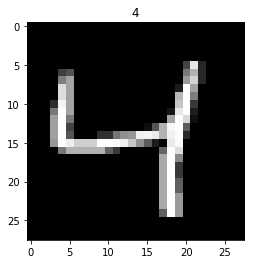

In [6]:
# plot one example
print(train_data.data.size())     # (60000, 28, 28)
print(train_data.targets.size())   # (60000)
plt.imshow(train_data.data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.targets[2])
plt.show()

In [7]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
#             nn.Tanh(),
#             nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
#             nn.Linear(3, 12),
#             nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        better_encoded = RelaxedBernoulliStraightThrough(0.01, logits=encoded).rsample()
        decoded = self.decoder(better_encoded)
        return better_encoded, decoded

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
Autoencoder in Cuda: True
Epoch:  0 | train loss: 0.2329


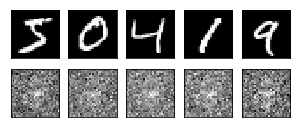

Epoch:  0 | train loss: 0.0498


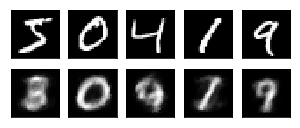

Epoch:  5 | train loss: 0.0420


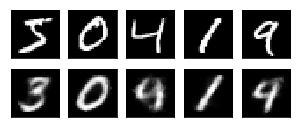

Epoch:  5 | train loss: 0.0382


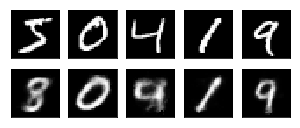

Epoch:  9 | train loss: 0.0341


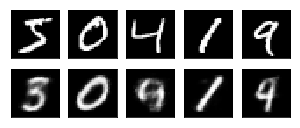

Epoch:  9 | train loss: 0.0427


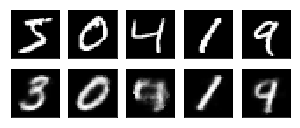

In [9]:
autoencoder = AutoEncoder().cuda()

print(autoencoder)
print("Autoencoder in Cuda:", next(autoencoder.parameters()).is_cuda)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss().cuda()

# original data (first row) for viewing
view_data = train_data.data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor).cuda()

for epoch in range(EPOCH):
    for step, (x, _) in enumerate(train_loader):
        batch = x.view(-1, 28*28).cuda()

        encoded, decoded = autoencoder(batch)

        loss = loss_func(decoded, batch)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 500 == 0 and (epoch % 5 == 0 or epoch == EPOCH-1):        
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.cpu().numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.cpu().numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.show(); plt.pause(0.05)
            
            
torch.cuda.empty_cache()
            